In [14]:
import pandas as pd
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from xgboost import XGBRegressor

import time
import my_tools
import pickle

In [30]:
def evaluate_model(model, X, y, scoring,  n_jobs, n_splits=10, n_repeats=3, random_state=1, error_score='raise'):
    
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    n_scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score)

    return mean(n_scores), std(n_scores)

def evaluate_model_complex(model, X, y, scoring,  n_jobs, n_splits=10, n_repeats=3, random_state=1):
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs)

    return scores

with open('vh_burn_costs.pickle', 'rb') as target:
	vehicle_ratings = pickle.load(target)


In [16]:
try:
    raw = pd.read_csv("W:/Shared With Me/Gibraltar/OTHER/AI Crowd Competition/Data/training.csv")
except:
    raw = pd.read_csv("C:/Users/Dev Work/Documents/aicrowd/insurancepricing/python/training.csv")

In [35]:
data = raw.copy()
data = my_tools.clean(data)
data = data[data['year'] == 1]
data = data[data['claim_amount'] > 0]
data = data.merge(vehicle_ratings, on="vh_make_model")


y = data['claim_amount']

exclude = ['claim_amount', 
            'id_policy', 
            'pol_no_claims_discount',
            'pol_duration',
            'pol_coverage', 
            'pol_payd', 
            'pol_pay_freq', 
            'pol_usage', 
            'vh_fuel', 
            'vh_make_model', 
            'vh_type', 
            'drv_age1',
            'drv_age_lic1',
            'drv_sex1', 
            'drv_drv2', 
            'drv_age2', 
            'drv_age_lic2', 
            'drv_sex2',
            'population',
            'town_surface_area',
            'year']

x = data[data.columns.difference(exclude)]


x_train, x_test, y_train, y_test = train_test_split(x, y)

In [36]:
data[data.columns.difference(exclude)]

,burn_cost,pol_sit_duration,vh_age,vh_speed,vh_value,vh_weight
0,122.052810,2,4.0,160.0,2088.0,0.0
1,122.052810,4,6.0,160.0,2088.0,0.0
2,122.052810,4,4.0,160.0,2088.0,0.0
3,122.052810,1,1.0,160.0,2088.0,0.0
4,122.052810,1,1.0,160.0,2088.0,0.0
...,...,...,...,...,...,...
2209,405.047500,1,3.0,239.0,65800.0,1742.0
2210,101.847234,2,9.0,162.0,11541.0,1130.0
2211,723.302500,2,7.0,154.0,33375.0,774.0
2212,292.917500,2,11.0,138.0,11129.0,944.0


In [50]:
n_trees = [25,50, 100] #[10,100,1000,5000]
max_depth = [5,10,20,50] #[x for x in range(1,12,2)]
learning_rate = [0.01, 0.1, 0.5,1]

In [49]:
'''
Warning, this cell will take a very, very long time to run without a decent PC.

I'd recommend not running on laptops...

'''

trees = {}

names = list()

start = time.time()

for n in n_trees:
    depths = {}
    for i in max_depth:
        results = {}
        for r in learning_rate:

            print(f"Tree: {n}, Depth: {i}, Learning Rate: {r}...")

            xg = XGBRegressor(n_estimators=n, max_depth=i, eta=r, eval_metric='logloss')
            xg.fit(x_train, y_train)

            scores = evaluate_model_complex(xg, x_test, y_test, 'neg_mean_absolute_error', -1)
            
            results[r] = {"scores":mean(scores), "model":xg}

        depths[i] = results.copy()
    trees[n] = depths.copy()

end = time.time()

print(f"Time Taken: {end-start}")

KeyboardInterrupt: 

In [39]:
rows = []

for tree in trees:
    for depth in trees[tree]:
        for rate in trees[tree][depth]:
            rows.append(tree, depth, rate, trees[tree][depth][rate]['scores'])

graph_data = pd.DataFrame(rows, columns=['trees', 'depth', 'rate', 'mean'])


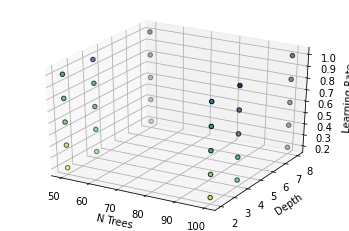

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_zscale='log'
ax.set_xscale='log'
ax.set_xlabel("N Trees")
ax.set_ylabel("Depth")
ax.set_zlabel("Learning Rate")
ax.scatter(graph_data['trees'].astype(float), graph_data['depth'].astype(float), graph_data['rate'].astype(float), c=graph_data['mean'], edgecolors='black')

In [41]:
peak_data = graph_data[graph_data['mean'] == graph_data['mean'].max()]
peak_models = []

for row_tuple in peak_data.iterrows():
    row = row_tuple[1]
    peak_models.append(trees[row['trees']][row['depth']][row['rate']]['model'])

In [42]:
for model in peak_models:
    with open('regression_severity_model.pickle', 'wb') as target:
        pickle.dump(model, target)

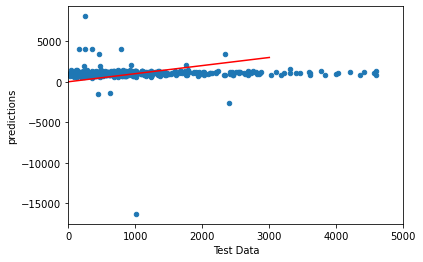

In [43]:
results = pd.DataFrame({"predictions": peak_models[0].predict(x_test), "Test Data":y_test})
results.plot(kind="scatter", x="Test Data", y="predictions", xlim=(0,5000))
plt.plot(range(0,3001),range(0,3001),c="red")

,id_policy,year,pol_no_claims_discount,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,drv_sex1,...,vh_age,vh_fuel,vh_type,vh_speed,vh_value,vh_weight,population,town_surface_area,claim_amount,burn_cost
0,PL042548,1,0.000,Max,2,2,Biannual,No,Professional,F,...,4.0,Gasoline,Tourism,160.0,2088.0,0.0,960,701.5,224.33,122.052810
1,PL039309,1,0.000,Max,5,4,Biannual,No,WorkPrivate,F,...,6.0,Gasoline,Tourism,160.0,2088.0,0.0,270,84.8,206.22,122.052810
2,PL026157,1,0.000,Max,4,4,Yearly,No,WorkPrivate,M,...,4.0,Gasoline,Tourism,160.0,2088.0,0.0,510,92.7,467.03,122.052810
3,PL083582,1,0.000,Max,20,1,Yearly,No,Retired,M,...,1.0,Gasoline,Tourism,160.0,2088.0,0.0,240,33.7,145.08,122.052810
4,PL093794,1,0.000,Max,18,1,Yearly,No,WorkPrivate,F,...,1.0,Gasoline,Tourism,160.0,2088.0,0.0,110,46.7,642.25,122.052810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2209,PL000057,1,0.000,Max,18,1,Monthly,No,WorkPrivate,F,...,3.0,Diesel,Tourism,239.0,65800.0,1742.0,2550,184.8,562.75,405.047500
2210,PL001981,1,0.483,Max,3,2,Monthly,No,WorkPrivate,F,...,9.0,Gasoline,Tourism,162.0,11541.0,1130.0,30,59.9,213.04,101.847234
2211,PL000621,1,0.000,Max,5,2,Yearly,No,Retired,M,...,7.0,Diesel,Commercial,154.0,33375.0,774.0,1700,138.7,1670.78,723.302500
2212,PL010827,1,0.000,Med2,26,2,Biannual,No,WorkPrivate,F,...,11.0,Gasoline,Tourism,138.0,11129.0,944.0,970,140.6,6237.06,292.917500


In [46]:
peak_models[0].feature_importances_


array([0.02967697, 0.34519428, 0.0373421 , 0.03435976, 0.53557   ,
       0.0178569 ], dtype=float32)